In [1]:
import os
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
from talib import  BBANDS, ROC, EMA, MACD
#from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter
#from scipy.stats import johnsonsu, skew, kurtosis
#from datetime import datetime
from statsmodels.graphics.tsaplots import  plot_pacf, plot_acf

data_dir = 'data5min'

# List all JSON files in the directory
json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]

# Initialize an empty list to store DataFrames
df_list = []

# Read each JSON file and append the DataFrame to the list
for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)
    df = pd.read_json(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
df_org = pd.concat(df_list, ignore_index=True)




# Compute olhc4
df_org['olhc4'] = (df_org['closedprices'] + df_org['highPrices'] + df_org['lowPrices'] + df_org['openPrices']) / 4
# Compute log returns
df_org['log_returns'] = np.log(df_org['closedprices'] / df_org['closedprices'].shift(1))
df_org['forward_returns'] = df_org['log_returns'].shift(-1)
df_org['momentum'] = np.log(df_org['closedprices']/df_org['closedprices'].shift(20))

df_org['SnapshotTime'] = pd.to_datetime(df_org['SnapshotTime'], format='ISO8601')

# Extract unique days
df_org['Date'] = df_org['SnapshotTime'].dt.date
unique_days = df_org['Date'].unique()

df_org.head()

,SnapshotTime,openPrices,highPrices,lowPrices,closedprices,olhc4,log_returns,forward_returns,momentum,Date
0,2024-11-18 08:00:00,7294.7,7295.5,7276.7,7278.7,7286.400,NaN,0.000591,NaN,2024-11-18
1,2024-11-18 08:05:00,7278.0,7284.0,7274.2,7283.0,7279.800,0.000591,0.000577,NaN,2024-11-18
2,2024-11-18 08:10:00,7282.7,7287.2,7282.2,7287.2,7284.825,0.000577,0.000412,NaN,2024-11-18
3,2024-11-18 08:15:00,7287.0,7290.2,7285.0,7290.2,7288.100,0.000412,-0.001125,NaN,2024-11-18
4,2024-11-18 08:20:00,7290.5,7292.5,7281.2,7282.0,7286.550,-0.001125,-0.001512,NaN,2024-11-18


In [2]:
up, mid, low = BBANDS(df_org.closedprices, timeperiod=5, nbdevup=0.5, nbdevdn=0.5, matype=0)
roc10= ROC(df_org.closedprices, timeperiod=10 )
roc13= ROC(df_org.closedprices, timeperiod=13 )
roc15= ROC(df_org.closedprices, timeperiod=15 )
roc20= ROC(df_org.closedprices, timeperiod=20 )
#kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)


kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.01) # 0.01 0.05


kf2 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.1) #.1 0001

kstmt = 1.618 * roc10 +  1.5*roc13 +  1.382 * roc15+ 1.236*roc20
#kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)

olhc4_filter, _ = kf.filter(df_org['closedprices'])
olhc4_filter2, _ = kf2.filter(df_org['closedprices'])
#

roc300= ROC(df_org.closedprices, timeperiod=50 )
roc400= ROC(df_org.closedprices, timeperiod=100 )
roc600= ROC(df_org.closedprices, timeperiod=150 )
roc800= ROC(df_org.closedprices, timeperiod=200 )
kstlt = 1.618 * EMA(roc300, 30) +  1.5*EMA(roc400,40) +  1.382 * EMA(roc600,60) + 1.236*EMA(roc800,80)

kstmtup, kstmtmid, kstmtlow = BBANDS(kstmt, timeperiod=30, nbdevup=1.1, nbdevdn=1.1, matype=0)

df_org['roc10'] = roc10
df_org['kstmt'] = kstmt 
df_org['kstmtup'] = kstmtup
df_org['kstmtmid'] = kstmtmid
df_org['kstmtlow'] =  kstmtlow
df_org['kstlt'] = kstlt 
df_org['up'] = up
df_org['low'] = low
df_org['olhc4_filter'] = olhc4_filter
df_org['olhc4_filter2'] = olhc4_filter2
df_org['upreturn'] = np.log(df_org['up'] / df_org['up'].shift(1))
df_org['lowreturn'] = np.log(df_org['low'] / df_org['low'].shift(1))

In [3]:
kf3 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.01) # 0.01 0.05


df_org.dropna(inplace=True)

kstmt_filter, _ = kf3.filter(df_org['kstmt'])
df_org['kstmt_filter'] = kstmt_filter



In [4]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Add traces for the initial plot (first day)
initial_day = unique_days[44] #16 17 4 5 6 8
print(initial_day)

df_day = df_org[df_org['Date'] == initial_day]



#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmt_filter']  , #-df_day['kstmt_filter_speed'] )*15,
#                         name = 'kstmt',
#                         opacity = 0.5), row=1, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmt_filter_speed'],
#                         name = 'kstmt',
#                         opacity = 1), row=1, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmtmid'],
#                         name = 'kstmtmid',
#                         opacity = 0.5), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmtup'],
                        line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'kst upper band',
                         opacity = 0.5), row=2, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmtlow'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=2, col=1)

mark = dict(color=[ 'yellow' if x >= 0 else 'red'   for x in df_day['kstmt_filter'] - df_day['kstmt_filter'].shift(1)])


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmt_filter'],
                          line_color = 'red',
                         name = 'kstmt',
                         mode='markers',
                         marker=mark,
                         opacity = 1), row=2, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstlt'],
                          line_color = 'yellow',
                         name = 'kstlt',
                         opacity = 1), row=2, col=1)

fig.append_trace(  go.Candlestick(
                x=df_day['SnapshotTime'],
                open=df_day['openPrices'],
                high=df_day['highPrices'],
                low=df_day['lowPrices'],
                close=df_day['closedprices']), row=3, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['olhc4'],
#                        line_color = 'red',
#                         name = 'filter',
#                         opacity = 1), row=3, col=1)


#fig.append_trace(go.Scatter(x=df_buy['SnapshotTime'], y=df_buy['closedprices'] + 20, mode='markers',
#    marker=dict(symbol='x', size=7, line=dict(width=1), color='green'), name = 'Buy'), row=3, col=1)

#fig.append_trace(go.Scatter(x=df_sell['SnapshotTime'], y=df_sell['closedprices'] - 20, mode='markers',
#    marker=dict(symbol='x', size=7, line=dict(width=1), color='red'), name = 'Sell'), row=3, col=1)




#mark = dict(color=[ 'yellow' if x == 0 else 'red' if x == -1 else 'green'  for x in df_day['signal']])
#mark = dict(color=[ 'yellow' if x == 0 else 'red' if x == 1 else 'green'  for x in df_day['state']])

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter'],
                        line_color = 'yellow',
                         name = 'filter',
                         opacity = 1, mode='markers'), row=3, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter2'],
                        line_color = 'red',
                         name = 'filter',
                         opacity = 1), row=3, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['up'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5), row=3, col=1)

fig.append_trace(  go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['low'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=3, col=1)

#fig.append_trace(  go.Scatter(x = df_day['SnapshotTime'],
#                         y = np.exp(df_day['backtest'].mul(1)).cumprod().mul(df_day['openPrices'].iloc[0]),
#                         line_color = 'blue',
#                         name = 'return',
#                         opacity = 1), row=3, col=1)



dropdown_buttons = [
    {
        'label': str(day),
        'method': 'update',
       'args': [
            {
                'x': [df_org[df_org['Date'] == day]['SnapshotTime']] * 11,
                'y': [
                    df_org[df_org['Date'] == day]['openPrices'],
                    df_org[df_org['Date'] == day]['highPrices'],
                    df_org[df_org['Date'] == day]['lowPrices'],
                    df_org[df_org['Date'] == day]['closedprices'],
                    df_org[df_org['Date'] == day]['olhc4'],
                    df_org[df_org['Date'] == day]['log_returns'],
                    df_org[df_org['Date'] == day]['kstmt'], 
                    df_org[df_org['Date'] == day]['kstmtup'], 
                    df_org[df_org['Date'] == day]['kstmtlow'],
                    df_org[df_org['Date'] == day]['up'],
                    df_org[df_org['Date'] == day]['low']
                ]
            },
            {
                'xaxis': {
                    'range': [
                        df_org[df_org['Date'] == day]['SnapshotTime'].min(),
                        df_org[df_org['Date'] == day]['SnapshotTime'].max()
                    ]
                },
                'yaxis2': {
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                },
                'yaxis': {
#                    'range': [
#                        df_org[df_org['Date'] == day]['kstmt'].min(),
#                        df_org[df_org['Date'] == day]['kstmt'].max()
#                    ]
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                }
            }
        ]
    }
    for day in unique_days
]



# Update layout to include dropdown menu and range slider for the second row
fig.update_layout(
    width=1790,
    height=4000,
    template='plotly_dark',
    xaxis1=dict(
        rangeslider=dict(
            visible=False
        )
    ),
     xaxis3=dict(
        rangeslider=dict(
            visible=True
        )
    )
    #,
    #updatemenus=[
    #   {
    #        'buttons': dropdown_buttons,
    #        'direction': 'down',
    #        'showactive': True,
    #    }
    #]
)

fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="ROC", row=1, col=1)

fig.show()

2025-01-28


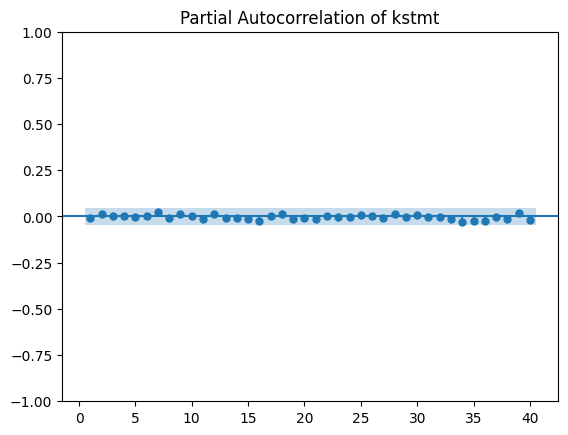

In [5]:
fig, ax = plt.subplots()


plot_pacf(df_org['log_returns'], ax=ax, method='ywm', lags=40, alpha=0.0001, use_vlines=True, title='Partial Autocorrelation of kstmt', zero=False)
#ax.set_ylim(-0.25, 0.25)

plt.show()